# Machine Learning con spotipy

Mi intención es predecir una canción en base al estado de ánimo, pero para ello primero hay que predecir el estado de ánimo.  
En primer lugar una vez tengamos nuestro dataset limpio (sin datos nulos, duplicados o características irrelevantes) y normalizadas las variables numéricas.

https://www.jcchouinard.com/pca-with-python/#PCA_Examples_From_This_Tutorial

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans

In [29]:
df = pd.read_csv(r"../data/no_lej_data.csv")

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 311 entries, 0 to 310
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Mood              311 non-null    object 
 1   song_name         311 non-null    object 
 2   artist_name       311 non-null    object 
 3   popularity        311 non-null    int64  
 4   danceability      311 non-null    float64
 5   energy            311 non-null    float64
 6   key               311 non-null    int64  
 7   loudness          311 non-null    float64
 8   mode              311 non-null    int64  
 9   speechiness       311 non-null    float64
 10  acousticness      311 non-null    float64
 11  instrumentalness  311 non-null    float64
 12  liveness          311 non-null    float64
 13  valence           311 non-null    float64
 14  tempo             311 non-null    float64
 15  duration_ms       311 non-null    int64  
 16  song_uri          311 non-null    object 
dt

Dejamos las variables relevantes:

In [31]:
dfml = df[['Mood','popularity','danceability','energy','loudness','instrumentalness','valence']]

In [32]:
#data o features // target o labels
target = dfml['Mood']
data_df = dfml.drop(columns=['Mood'])
X = data_df.values
y = target.values

Hay que estandarizar los datos.  
**¿Estandarización o normalización?**  


La normalización y estandarización son técnicas comunes de preprocesamiento de datos que se utilizan para escalar las características a un rango específico. Esto es especialmente importante en algoritmos de machine learning que se basan en cálculos de distancias o magnitudes.  
- **Normalización**: La normalización escala los valores de cada característica para que estén en el rango [0, 1].  
-----> Fórmula: ***X_normalized = (X - X_min) / (X_max - X_min)***  
- **Estandarización**: La estandarización escala los valores de cada característica para que tengan media cero y desviación estándar uno.  
-----> Fórmula: ***X_standardized = (X - mean) / std***  

*Código:*  

**NORMALIZACIÓN:**  
import pandas as pd  
from sklearn.preprocessing import MinMaxScaler  


'# Crea un objeto MinMaxScaler  
scaler = MinMaxScaler()  


'# Normaliza las características y obtén un nuevo DataFrame con los valores normalizados  
X_normalized = scaler.fit_transform(features_df)  


'# Convierte el nuevo array normalizado a un nuevo DataFrame  
normalized_features_df = pd.DataFrame(X_normalized, columns=features_df.columns)  


**ESTANDARIZACIÓN:**  
from sklearn.preprocessing import StandardScaler  


'# Crea un objeto StandardScaler  
scaler = StandardScaler()  


'# Estandariza las características y obtén un nuevo DataFrame con los valores estandarizados  
X_standardized = scaler.fit_transform(features_df)  


'# Convierte el nuevo array estandarizado a un nuevo DataFrame
standardized_features_df = pd.DataFrame(X_standardized, columns=features_df.columns)

In [33]:
x_scaled = StandardScaler().fit_transform(X)

No todas las características son necesariamente útiles para la predicción. Por lo tanto, podemos eliminar esas características ruidosas y crear un modelo más rápido.  


El PCA es un candidato ideal para realizar este tipo de reducción de dimensiones.

Primero vamos a ver cuantos parámetros son óptimos para aplicarlo en el algoritmo a través de la regla del codo:

c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



[]

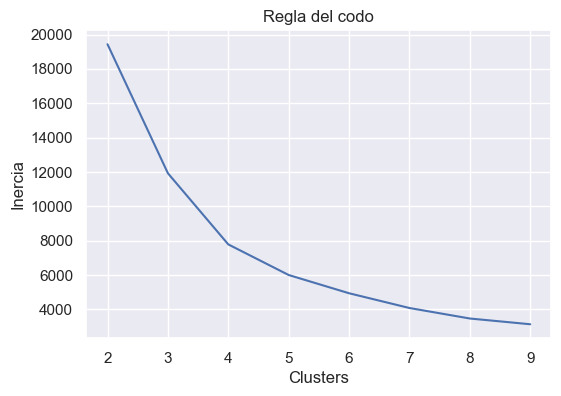

In [34]:
# Iteramos y calculamos inercia
inertia_dct = {}
for i in range(2, 10):
    km = KMeans(n_clusters=i, max_iter=150, random_state=42)
    km.fit(X)
    inertia_dct[i] = km.inertia_

# Dibujamos
fig, ax = plt.subplots(figsize=(6, 4))
sns.lineplot(x=list(inertia_dct.keys()), y=list(inertia_dct.values()), ax=ax)
ax.set_title('Regla del codo')
ax.set_xlabel('Clusters')
ax.set_ylabel('Inercia')
plt.plot()

En este caso un número razonable de parámetros serían 3 o 4.  
**Selecciono 3 componentes**.

In [35]:
target_names = {
    0: 'Happy',
    1: 'Sad',
    2: 'Anger',
    3: 'Focus'
}

# Agregar las etiquetas de emociones directamente al DataFrame data_df
y_mapped = target.map({v: k for k, v in target_names.items()})

pca = PCA(n_components=3) # 3 según la regla del codo
X_pca = pca.fit_transform(x_scaled)

print('Shape before PCA: ', x_scaled.shape)
print('Shape after PCA: ', X_pca.shape)
 
pca_df = pd.DataFrame(
    data=X_pca, 
    columns=['PC1', 'PC2', 'PC3'])

# Agregar las etiquetas de emociones mapeadas al DataFrame pca_df
pca_df['target'] = y_mapped

Shape before PCA:  (311, 6)
Shape after PCA:  (311, 3)


In [36]:
pca_df

,PC1,PC2,PC3,target
0,-2.102558,0.381176,-1.540106,0
1,-2.838498,-0.752417,-0.625187,0
2,-1.527168,0.325996,-1.715309,0
3,-2.163228,0.166225,-1.100258,0
4,-2.567593,-2.490314,-0.358864,0
...,...,...,...,...
306,2.981662,-0.205821,0.348069,3
307,2.378752,-0.739995,0.725206,3
308,2.881549,0.452108,0.330273,3
309,2.561146,-0.124217,0.560291,3


Estos nuevos valores de componentes principales retienen la mayor parte de la información relevante de tus datos originales mientras reducen la dimensionalidad del conjunto de datos.

¿Cuánto afecta cada variable en la predicción?

La varianza explicada, o valor propio, en el PCA muestra la varianza que puede atribuirse a cada uno de los componentes principales.

In [21]:
pca.explained_variance_

array([3.91927683, 0.92571478, 0.65754724])

Los valores de pca.explained_variance_ nos indican cuánta varianza explica cada componente principal en términos generales, pero no nos permiten determinar directamente si el tercer componente es una característica ruidosa. Se necesita un análisis más profundo y detallado de los componentes principales y las características originales para hacer esa evaluación.

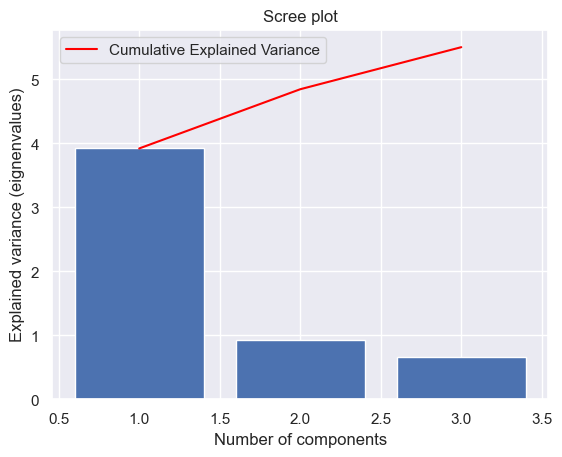

In [22]:
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
 
from sklearn.decomposition import PCA
sns.set()
 
# Reduce from 4 to 3 features with PCA
pca = PCA(n_components=3)
 
# Fit and transform data
reduced_features = pca.fit_transform(x_scaled)
 
# Bar plot of explained_variance
plt.bar(
    range(1,len(pca.explained_variance_)+1),
    pca.explained_variance_
    )
 
plt.plot(
    range(1,len(pca.explained_variance_ )+1),
    np.cumsum(pca.explained_variance_),
    c='red',
    label='Cumulative Explained Variance')
 
plt.legend(loc='upper left')
plt.xlabel('Number of components')
plt.ylabel('Explained variance (eignenvalues)')
plt.title('Scree plot')
 
plt.show()

Para evaluar si existe una característica ruidosa en tus datos, o más específicamente, en la visualización de PCA, aquí hay algunas pautas a considerar:

Caída abrupta en la varianza explicada: Busca un punto en el gráfico donde haya una caída abrupta en la varianza explicada por cada componente principal. En el Scree plot, esta caída se ve como un "codo" en la curva de varianza explicada. El punto en el que ocurre el "codo" puede indicar el número óptimo de componentes principales para retener en tu conjunto de datos.

Porcentaje de varianza explicada: Observa el porcentaje de varianza explicada acumulada en la curva roja (varianza acumulada). El gráfico muestra cómo se acumula la varianza explicada a medida que aumenta el número de componentes principales. Si la curva roja se estabiliza o muestra una pendiente menos pronunciada, esto puede indicar que agregar más componentes principales no aporta mucha información adicional y, por lo tanto, esos componentes pueden ser menos significativos o ruidosos.

Interpretación de componentes principales: Si bien el Scree plot puede ayudarte a determinar cuántos componentes principales son necesarios para retener la varianza, también es importante analizar los propios componentes principales (pca.components_) para comprender qué características o combinaciones de características contribuyen más a cada componente. Esto te puede dar una idea de qué características son más relevantes y cuáles podrían considerarse ruidosas.

In [23]:
import plotly.graph_objects as go

# Prepare 3D graph
fig = go.Figure()

# Plot scaled features
xdata = x_scaled[:, 0]
ydata = x_scaled[:, 1]
zdata = x_scaled[:, 2]

# Plot 3D scatter plot
fig.add_trace(go.Scatter3d(
    x=xdata,
    y=ydata,
    z=zdata,
    mode='markers',
    marker=dict(
        size=5,
        color=zdata,
        colorscale='Viridis',
    )
))

# Set title and axis labels
fig.update_layout(title='3D Scatter',
                  scene=dict(
                      xaxis_title='PC1',
                      yaxis_title='PC2',
                      zaxis_title='PC3',
                      xaxis=dict(ticks='outside'),
                      yaxis=dict(ticks='outside'),
                      zaxis=dict(ticks='outside')
                  ))

# Show the interactive plot
fig.show()

Si los puntos están dispersos uniformemente o si hay grupos de puntos muy cercanos entre sí. Si hay agrupaciones muy compactas, puede indicar que algunas características están contribuyendo a formar esos grupos y podrían ser relevantes. Por otro lado, si los puntos están dispersos en un amplio rango, algunas características pueden tener baja varianza y ser candidatas para ser consideradas ruidosas.  
En este caso no se ve muy claro.

In [24]:
pca2 = PCA(n_components=2) # 2 según la regla del codo
X_pca2 = pca2.fit_transform(x_scaled)

pca_df2 = pd.DataFrame(
    data=X_pca2, 
    columns=['PC1', 'PC2'])
# Agregar las etiquetas de emociones mapeadas al DataFrame pca_df
pca_df2['target'] = y_mapped

In [25]:
pca_df2

,PC1,PC2,target
0,-2.102558,0.381176,NaN
1,-2.838498,-0.752417,NaN
2,-1.527168,0.325996,NaN
3,-2.163228,0.166225,NaN
4,-2.567593,-2.490314,NaN
...,...,...,...
306,2.981662,-0.205821,NaN
307,2.378752,-0.739995,NaN
308,2.881549,0.452108,NaN
309,2.561146,-0.124217,NaN


Dividir los datos en conjuntos de entrenamiento y prueba: 

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

Entrenamos el modelo de clasificación:

In [38]:
from sklearn.ensemble import RandomForestClassifier

# Ejemplo utilizando RandomForestClassifier, pero puedes elegir otro modelo según tus preferencias.
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

Realizamos predicciones:

In [39]:
y_pred = clf.predict(X_test)

Evaluamos el modelo:

In [40]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
confusion_mat = confusion_matrix(y_test, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:\n", report)
print("Confusion Matrix:\n", confusion_mat)

Accuracy: 0.873015873015873
Classification Report:
               precision    recall  f1-score   support

       Anger       0.89      0.67      0.76        12
       Focus       1.00      1.00      1.00        17
       Happy       0.77      0.94      0.85        18
         Sad       0.87      0.81      0.84        16

    accuracy                           0.87        63
   macro avg       0.88      0.86      0.86        63
weighted avg       0.88      0.87      0.87        63

Confusion Matrix:
 [[ 8  0  3  1]
 [ 0 17  0  0]
 [ 0  0 17  1]
 [ 1  0  2 13]]


PREGUNTAR A ANDRES!!!!

In [11]:
target_names = {
    0:'Happy',
    1:'Sad',
    2:'Anger',
    3:'Focus'
}
pca_df['target'] = y
pca_df['target'] = pca_df['target'].map(target_names)
 
pca_df

,PC1,PC2,PC3,target
0,-2.102558,0.381176,-1.540106,NaN
1,-2.838498,-0.752417,-0.625187,NaN
2,-1.527168,0.325996,-1.715309,NaN
3,-2.163228,0.166225,-1.100258,NaN
4,-2.567593,-2.490314,-0.358864,NaN
...,...,...,...,...
306,2.981662,-0.205821,0.348069,NaN
307,2.378752,-0.739995,0.725206,NaN
308,2.881549,0.452108,0.330273,NaN
309,2.561146,-0.124217,0.560291,NaN


In [7]:
dfml['Mood'].unique()

array(['Happy', 'Sad', 'Anger', 'Focus'], dtype=object)

In [ ]:
target_names = {
    0:'Happy',
    1:'Sad',
    2:'Anger',
    3:'Focus'
}
